# Predicting the NBA MVP Top 5 Voting

## Importing Packages and Loading in Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)

In [2]:
stats_df = pd.read_csv(r'Documents\Cleaned Stats for NBA MVP.csv')

## Data Cleaning

In [3]:
# Checking for nulls
stats_df.isnull().sum()

Player        0
Pos           0
Age           0
Tm            0
G             0
GS            0
MP            0
FG            0
FGA           0
FG%          58
3P            0
3PA           0
3P%        2028
2P            0
2PA           0
2P%          99
eFG%         58
FT            0
FTA           0
FT%         516
ORB           0
DRB           0
TRB           0
AST           0
STL           0
BLK           0
TOV           0
PF            0
PTS           0
Year          0
Pts Won       0
Pts Max       0
Share         0
W             0
L             0
W/L%          0
GB            0
PS/G          0
PA/G          0
SRS           0
Team          0
dtype: int64

In [4]:
stats_df[stats_df['FG%'].isnull()][['Player','FGA']].head(10)

,Player,FGA
116,Ade Murkey,0.0
141,Adrian Caldwell,0.0
292,Alex Scales,0.0
642,Andy Panko,0.0
988,Ashton Hagans,0.0
1114,Ben Moore,0.0
1200,Billy Thompson,0.0
1523,Brandon Williams,0.0
1662,Brian Skinner,0.0
1691,Bruce Bowen,0.0


**Thoughts**

Looking at the null percentage columns, it appears that the reason these columns have null values is that the player did not register any stats in these respective column. For example, a null 3P% in this dataset indicates that a player did not attempt a 3 pointer. Therefore, we can just fill the NAs with 0.

In [5]:
stats_df = stats_df.fillna(0)

## Selecting Predictors

In [6]:
stats_df.columns

Index(['Player', 'Pos', 'Age', 'Tm', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%', 'ORB',
       'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 'Year',
       'Pts Won', 'Pts Max', 'Share', 'W', 'L', 'W/L%', 'GB', 'PS/G', 'PA/G',
       'SRS', 'Team'],
      dtype='object')

In [7]:
# Only using numeric columns for our model

predictors = ['Age', 'G', 'GS', 'MP', 'FG', 'FGA', 'FG%', '3P',
       '3PA', '3P%', '2P', '2PA', '2P%', 'eFG%', 'FT', 'FTA', 'FT%',
       'ORB', 'DRB', 'TRB', 'AST', 'STL', 'BLK', 'TOV', 'PF', 'PTS', 
        'W/L%', 'PS/G', 'PA/G',
       'SRS']

## Creating Train and Test Sets

To predict the MVP in 2022, we will create a training set that contains data from 1992-2021, and a test set with data for 2022.

In [8]:
train = stats_df[stats_df['Year'] < 2022]
test = stats_df[stats_df['Year'] == 2022]

## Creating the Ridge Regression Model

I am choosing to try the Ridge Regression in an effort to reduce overfitting, considering that we have a fairly long list of predictors, with many of these predictors having collinearity. 

In [9]:
from sklearn.linear_model import Ridge

reg = Ridge(alpha=0.1)

In [10]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(train[predictors])
X_test = sc.fit_transform(test[predictors])

reg.fit(X_train, train['Share'])

Ridge(alpha=0.1)

In [11]:
predictions = reg.predict(X_test)

In [12]:
predictions = pd.DataFrame(predictions, columns = ['predictions'], index = test.index)
predictions

,predictions
39,0.002895
50,0.011123
54,-0.002639
71,-0.003321
73,-0.015274
...,...
14206,0.054442
14226,-0.076773
14244,-0.011203
14255,-0.018365


In [13]:
combined = pd.concat([test[['Player','Share']],predictions], axis = 1)

In [14]:
combined.sort_values('Share',ascending=False).head(10)

,Player,Share,predictions
10377,Nikola Jokić,0.875,0.155333
6988,Joel Embiid,0.706,0.155236
5115,Giannis Antetokounmpo,0.595,0.182847
3793,Devin Booker,0.216,0.056258
8848,Luka Dončić,0.146,0.132183
6507,Jayson Tatum,0.043,0.068692
5805,Ja Morant,0.010,0.084612
12536,Stephen Curry,0.004,0.082424
2409,Chris Paul,0.002,0.055408
3427,DeMar DeRozan,0.001,0.059994


## Evaluating the Regression Model

### Mean Squared Error

In [15]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(combined['Share'],combined['predictions'])
print('The mean squared error of the regression model is {}'.format(mse))

The mean squared error of the regression model is 0.002194576192679048


**Thoughts**

This error metric isn't going to be very valuable in this analysis considering that we really only care about predicting who will finish in the top 5 of MVP voting. Most players in the league will not receive any MVP votes, and we aren't trying to predict MVP votes for hundreds of players that don't receive votes. Because we are most interested in accurately predicting the top 5, we can use a custom function devise an average precision score.

### Average Precision

In [16]:
# Creating a df that ranks the players by actual voting share
actual = combined.sort_values("Share", ascending=False)
actual['Rank'] = list(range(1,actual.shape[0]+1))

In [17]:
# Creating a df that ranks the players by predicted voting share
predicted = combined.sort_values('predictions', ascending = False)
predicted['Predicted Rank'] = list(range(1,predicted.shape[0]+1))

In [18]:
actual.merge(predicted, on ='Player').head(10)

,Player,Share_x,predictions_x,Rank,Share_y,predictions_y,Predicted Rank
0,Nikola Jokić,0.875,0.155333,1,0.875,0.155333,2
1,Joel Embiid,0.706,0.155236,2,0.706,0.155236,3
2,Giannis Antetokounmpo,0.595,0.182847,3,0.595,0.182847,1
3,Devin Booker,0.216,0.056258,4,0.216,0.056258,23
4,Luka Dončić,0.146,0.132183,5,0.146,0.132183,4
5,Jayson Tatum,0.043,0.068692,6,0.043,0.068692,16
6,Ja Morant,0.010,0.084612,7,0.010,0.084612,9
7,Stephen Curry,0.004,0.082424,8,0.004,0.082424,10
8,Chris Paul,0.002,0.055408,9,0.002,0.055408,26
9,DeMar DeRozan,0.001,0.059994,10,0.001,0.059994,21


Creating an average precision function that tells us how accurate we are on placing the correct players in the top 5 of MVP voting.

In [19]:
def find_ap(combined):
    actual = combined.sort_values('Share',ascending=False).head(5)
    predicted = combined.sort_values('predictions',ascending=False)
    ps = []
    found = 0
    seen = 1
    for index, row in predicted.iterrows():
        if row['Player'] in actual['Player'].values:
            found += 1
            ps.append(found/seen)
        seen += 1
    return sum(ps)/len(ps)

In [20]:
print('The average precision score for our model in 2022 is: {}'.format(find_ap(combined)))

The average precision score for our model in 2022 is: 0.8434782608695652


Our average precision score for predicting the top 5 MVP players is 0.84. In other words, our model was precise for predicting players in the top 5 MVP voting 84% of the time. This is a great score for predicting 2022, but we can also test our model by predicting the MVP for previous years.

## Backtesting for Previous Years

Generating predictions for 1997-2021. Starting the backtesting at the 5th year within the full range of years so that we can make sure we have enough historical data to make predictions.

In [21]:
years = list(range(1992, 2023))

In [22]:
# Function to add an actual voting rank, a predicted rank, and the difference between actual and predicted

def add_ranks(combined):
    combined = combined.sort_values('Share', ascending = False)
    combined['Rank'] = list(range(1,combined.shape[0]+1))
    combined = combined.sort_values('predictions', ascending = False)
    combined['Predicted Rank'] = list(range(1,combined.shape[0]+1))
    combined['Diff'] = combined['Rank'] - combined['Predicted Rank']
    return combined

In [23]:
# Function that returns the average precision score and predictions for the last 25 years

def backtest(stats, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = stats[stats["Year"] < year].copy()
        test = stats[stats["Year"] == year].copy()
        sc.fit(train[predictors])
        train[predictors] = sc.transform(train[predictors])
        test[predictors] = sc.transform(test[predictors])
        model.fit(train[predictors],train["Share"])
        predictions = model.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)
        combined = pd.concat([test[["Player","Year", "Share"]], predictions], axis=1)
        combined = add_ranks(combined)
        all_predictions.append(combined)
        aps.append(find_ap(combined))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [24]:
mean_ap, aps, all_predictions = backtest(stats_df, reg, years[5:], predictors)

In [25]:
print('The average precision score for our model backtesting is {}'.format(mean_ap))

The average precision score for our model backtesting is 0.7163411286514896


**Thoughts**

Our model is less accurate at predicting the top 5 MVP voting list across previous years compared to 2022, but still has overall good accuracy.

## Diagnostics

In [26]:
# Looking at the 10 biggest prediction discrepancies for players in the top 5
top_discrepancy = all_predictions[all_predictions['Rank']<=5].sort_values('Diff').head(10)
top_discrepancy

,Player,Year,Share,predictions,Rank,Predicted Rank,Diff
6371,Jason Kidd,2002,0.712,0.026798,2,59,-57
12638,Steve Nash,2005,0.839,0.031580,1,53,-52
5142,Glen Rice,1997,0.117,0.033881,5,52,-47
2180,Chauncey Billups,2006,0.344,0.044201,5,42,-37
6861,Joakim Noah,2014,0.258,0.046224,4,39,-35
10780,Peja Stojaković,2004,0.228,0.035792,4,37,-33
12639,Steve Nash,2006,0.739,0.052811,1,33,-32
2408,Chris Paul,2021,0.138,0.073279,5,33,-28
12640,Steve Nash,2007,0.785,0.072264,2,22,-20
6368,Jason Kidd,1999,0.135,0.053321,5,22,-17


**Thoughts**

To understand why these players might have been predicted to finish so low in the MVP race, I will try to get a sense of how their stats stacked up to the rest of the 5 players for the respective year.

In [27]:
# Df containing all top 5 voted players for each year
top5_predictions = all_predictions[all_predictions['Rank']<=5]

In [28]:
# Adding select stats for each player/year
top5_predictions = top5_predictions.join(stats_df[['W/L%','PTS','AST','TRB','3P','FG%','FTA']])

In [29]:
top5_predictions.head()

,Player,Year,Share,predictions,Rank,Predicted Rank,Diff,W/L%,PTS,AST,TRB,3P,FG%,FTA
7640,Karl Malone,1997,0.857,0.191757,1,2,-1,0.780,27.4,4.5,9.9,0.0,0.550,8.4
9746,Michael Jordan,1997,0.832,0.170557,2,3,-1,0.841,29.6,4.3,5.9,1.4,0.486,7.0
5217,Grant Hill,1997,0.327,0.128305,3,7,-4,0.659,21.4,7.3,9.0,0.1,0.496,7.9
13045,Tim Hardaway,1997,0.207,0.060394,4,20,-16,0.744,20.3,8.6,3.4,2.5,0.415,4.5
5142,Glen Rice,1997,0.117,0.033881,5,52,-47,0.659,26.8,2.0,4.0,2.6,0.477,6.8


In [30]:
# Converting the stats to ratios compared to the other top 5 vote-getters for the year
top5_ratios = top5_predictions[['Year','W/L%','PTS','AST','TRB','3P','FG%','FTA']].groupby('Year').apply(lambda x: x/x.mean())
top5_ratios

,Year,W/L%,PTS,AST,TRB,3P,FG%,FTA
7640,1.0,1.058919,1.091633,0.842697,1.537267,0.000000,1.134488,1.213873
9746,1.0,1.141732,1.179283,0.805243,0.916149,1.060606,1.002475,1.011561
5217,1.0,0.894651,0.852590,1.367041,1.397516,0.075758,1.023102,1.141618
13045,1.0,1.010046,0.808765,1.610487,0.527950,1.893939,0.856023,0.650289
5142,1.0,0.894651,1.067729,0.374532,0.621118,1.969697,0.983911,0.982659
...,...,...,...,...,...,...,...,...
5115,1.0,0.958989,1.046919,0.923567,1.132813,0.572917,1.080923,1.347518
6988,1.0,0.958989,1.071429,0.668790,1.142578,0.729167,0.975371,1.394799
10377,1.0,0.901943,0.948880,1.257962,1.347656,0.677083,1.139562,0.744681
8848,1.0,0.977490,0.994398,1.385350,0.888672,1.614583,0.893276,0.886525


In [31]:
# Adding the stat ratios from above to the df that contains the top 10 prediction discrepancies
top_discrepancy_ratio = top_discrepancy.join(top5_ratios[['W/L%','PTS','AST','TRB','3P','FG%','FTA']])
top_discrepancy_ratio

,Player,Year,Share,predictions,Rank,Predicted Rank,Diff,W/L%,PTS,AST,TRB,3P,FG%,FTA
6371,Jason Kidd,2002,0.712,0.026798,2,59,-57,0.962940,0.621827,1.806569,0.827664,2.187500,0.815263,0.406504
12638,Steve Nash,2005,0.839,0.031580,1,53,-52,1.103006,0.670996,2.060932,0.428571,1.666667,1.011281,0.398010
5142,Glen Rice,1997,0.117,0.033881,5,52,-47,0.894651,1.067729,0.374532,0.621118,1.969697,0.983911,0.982659
2180,Chauncey Billups,2006,0.344,0.044201,5,42,-37,1.171171,0.707728,1.303030,0.541958,1.210526,0.893162,0.846561
6861,Joakim Noah,2014,0.258,0.046224,4,39,-35,0.881555,0.519802,0.992647,1.419598,0.000000,0.939106,0.535714
10780,Peja Stojaković,2004,0.228,0.035792,4,37,-33,0.958571,1.054007,0.603448,0.654886,3.571429,1.020408,0.776119
12639,Steve Nash,2006,0.739,0.052811,1,33,-32,0.989489,0.719204,1.590909,0.734266,1.000000,1.094017,0.462963
2408,Chris Paul,2021,0.138,0.073279,5,33,-28,1.098356,0.624049,1.403785,0.530660,0.728155,0.949030,0.375723
12640,Steve Nash,2007,0.785,0.072264,2,22,-20,1.097345,0.761671,1.946309,0.494350,1.721311,1.055975,0.452055
6368,Jason Kidd,1999,0.135,0.053321,5,22,-17,0.833333,0.773102,2.297872,0.781609,2.142857,0.942675,0.586797


In [32]:
# Highlighting the ratios that are greater than the average for the top 5 of the respective year

def highlight_cells(value):
    highlight = 'background-color: lightred;'
    default = 'background-color: lightgreen'
    if value < 1:
        return highlight
    else: return default

top_discrepancy_ratio.style.applymap(highlight_cells, subset = ['W/L%','PTS','AST','TRB','3P','FG%','FTA'])

,Player,Year,Share,predictions,Rank,Predicted Rank,Diff,W/L%,PTS,AST,TRB,3P,FG%,FTA
6371,Jason Kidd,2002,0.712000,0.026798,2,59,-57,0.962940,0.621827,1.806569,0.827664,2.187500,0.815263,0.406504
12638,Steve Nash,2005,0.839000,0.031580,1,53,-52,1.103006,0.670996,2.060932,0.428571,1.666667,1.011281,0.398010
5142,Glen Rice,1997,0.117000,0.033881,5,52,-47,0.894651,1.067729,0.374532,0.621118,1.969697,0.983911,0.982659
2180,Chauncey Billups,2006,0.344000,0.044201,5,42,-37,1.171171,0.707728,1.303030,0.541958,1.210526,0.893162,0.846561
6861,Joakim Noah,2014,0.258000,0.046224,4,39,-35,0.881555,0.519802,0.992647,1.419598,0.000000,0.939106,0.535714
10780,Peja Stojaković,2004,0.228000,0.035792,4,37,-33,0.958571,1.054007,0.603448,0.654886,3.571429,1.020408,0.776119
12639,Steve Nash,2006,0.739000,0.052811,1,33,-32,0.989489,0.719204,1.590909,0.734266,1.000000,1.094017,0.462963
2408,Chris Paul,2021,0.138000,0.073279,5,33,-28,1.098356,0.624049,1.403785,0.530660,0.728155,0.949030,0.375723
12640,Steve Nash,2007,0.785000,0.072264,2,22,-20,1.097345,0.761671,1.946309,0.494350,1.721311,1.055975,0.452055
6368,Jason Kidd,1999,0.135000,0.053321,5,22,-17,0.833333,0.773102,2.297872,0.781609,2.142857,0.942675,0.586797


**Thoughts**

In the above dataframe, I highlighted in green all of the values that are greater than the average value for that statistic in the given year among other top 5 vote-getters. The lack of green in the PTS, TRB, and FTA columns show that many of these players that had a large MVP prediction discreption had less favorable averages in these statistics. Points per game is often a statistic that most fans associate with the MVP, and floor generals like Jason Kidd and Steve Nash, or a defensive anchor like Joakim Noah don't stack up to their cohorts. I also find it interesting that these 10 players were all below the average for for free throws attempted (FTA).

### Which Predictors are Most Important to the Model?

Which are the top coefficients in the model?

In [33]:
model_coef = pd.concat([pd.Series(predictors), pd.Series(reg.coef_), abs(pd.Series(reg.coef_))], axis =1).sort_values(2,ascending=False).round(3)
model_coef.drop(2, axis = 1, inplace=True)
model_coef.rename(columns = {0:'Predictor', 1: 'Coefficient'})

,Predictor,Coefficient
19,TRB,-0.069
18,DRB,0.061
11,2PA,-0.061
25,PTS,0.045
3,MP,-0.041
10,2P,0.030
5,FGA,0.021
15,FTA,0.020
8,3PA,-0.019
17,ORB,0.019


## Creating a Random Forest Regression and Comparing with the Ridge Regression

Creating a Random Forest regression model to predict the last 25 years of MVPs and then comparing the precision score to the Ridge regression model for the same timeframe.

### Random Forest

In [34]:
# Customizing the backtest function to be suitable for the Random Forest model
# where we aren't standardizing the predictors

def rf_backtest(stats, model, years, predictors):
    aps = []
    all_predictions = []
    for year in years:
        train = stats[stats["Year"] < year]
        test = stats[stats["Year"] == year]
        model.fit(train[predictors],train["Share"])
        predictions = model.predict(test[predictors])
        predictions = pd.DataFrame(predictions, columns=["predictions"], index=test.index)
        combination = pd.concat([test[["Player","Year", "Share"]], predictions], axis=1)
        combination = add_ranks(combination)
        all_predictions.append(combination)
        aps.append(find_ap(combination))
    return sum(aps) / len(aps), aps, pd.concat(all_predictions)

In [35]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators = 100, random_state = 42, min_samples_split = 5)

mean_ap_rf, aps_rf, all_predictions_rf = rf_backtest(stats_df, rf, years[5:], predictors)

In [36]:
print('Random Forest average precision score = {}'.format(mean_ap_rf))

Random Forest average precision score = 0.7255686314800027


In [37]:
# Top 5 for 2022 compared to the Random Forest prediction
all_predictions_rf[(all_predictions_rf['Rank'] <= 5) & (all_predictions_rf['Year'] == 2022)].sort_values(['Year', 'Rank'])

,Player,Year,Share,predictions,Rank,Predicted Rank,Diff
10377,Nikola Jokić,2022,0.875,0.319308,1,5,-4
6988,Joel Embiid,2022,0.706,0.410208,2,3,-1
5115,Giannis Antetokounmpo,2022,0.595,0.345835,3,4,-1
3793,Devin Booker,2022,0.216,0.534565,4,1,3
8848,Luka Dončić,2022,0.146,0.235631,5,6,-1


#### Visualizing the Average Precision Scores for the Random Forest

In [38]:
rf_aps_df = pd.DataFrame({'Year': years[5:], 'aps': aps_rf, 'mean_ap': mean_ap_rf})
rf_aps_df['Above Average'] = rf_aps_df['aps']> rf_aps_df['mean_ap']

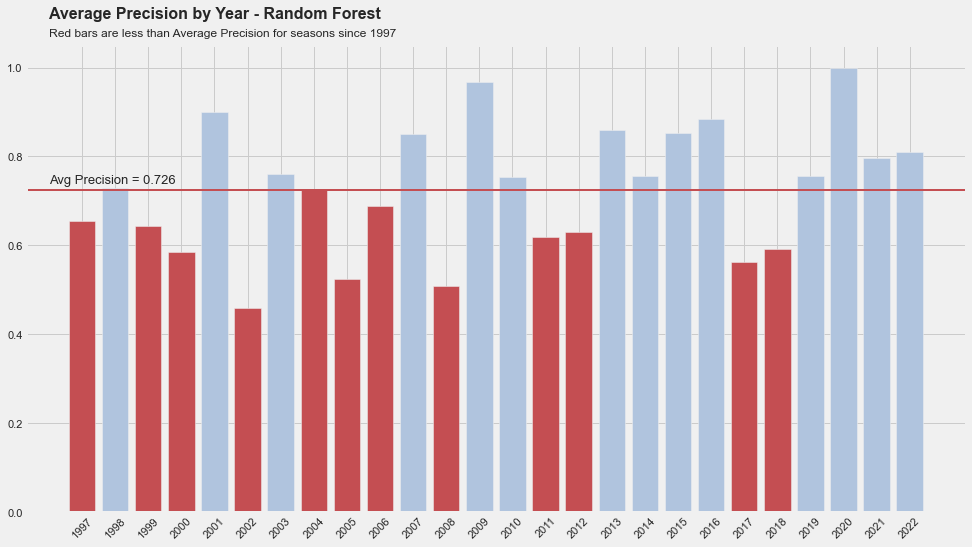

In [39]:
rounded_mean_ap_rf = round(mean_ap_rf, 3)

colors = []
for ap in aps_rf:
    if ap > mean_ap_rf:
        colors.append('lightsteelblue')
    else:
        colors.append('r')
        
plt.style.use('fivethirtyeight')        
fig = plt.figure(figsize=(15,8))
plt.bar(rf_aps_df['Year'], rf_aps_df['aps'], color = colors)
plt.axhline(y=mean_ap_rf, color='r', linestyle='-', linewidth = 2)
plt.xticks(years[5:], rotation = 45)
plt.text(1996 ,.74,'Avg Precision = {}'.format(rounded_mean_ap_rf), fontsize = 13)
plt.text(x=1996, y=1.11 , s='Average Precision by Year - Random Forest', fontsize=16, fontweight='semibold')
plt.text(x=1996, y=1.07 , s='Red bars are less than Average Precision for seasons since 1997', fontsize=12)
plt.show()

#### Visualizing a Decision Tree from the Random Forest

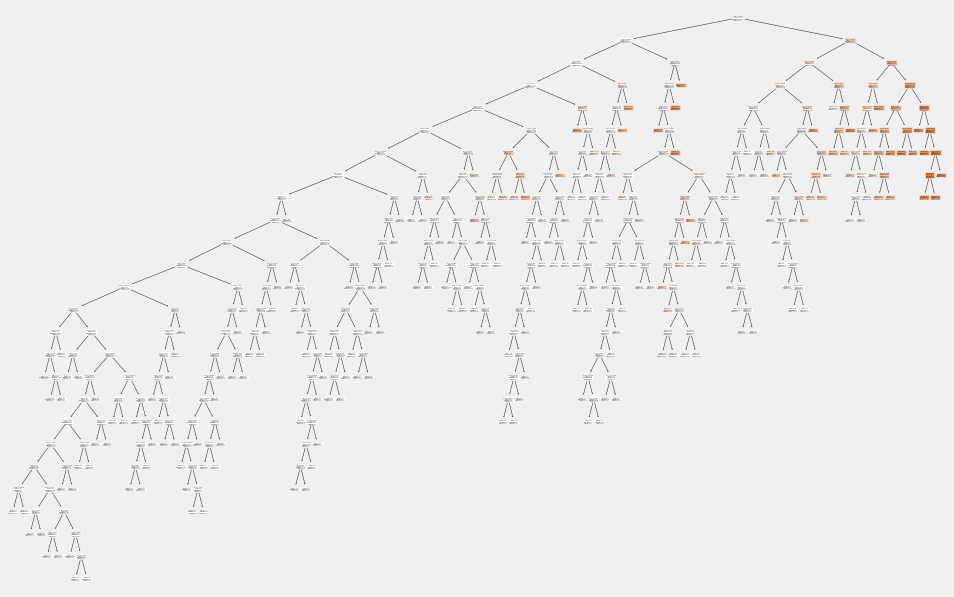

In [40]:
from sklearn import tree
fig = plt.figure(figsize=(15,10))
tree.plot_tree(rf.estimators_[8], filled = True)
plt.show()

Creating a smaller Random Forest by limiting the depth of the tree to 4 level to get a sense for the variables the tree is splitting on.

In [41]:
rf_small = RandomForestRegressor(n_estimators=100, min_samples_split = 5, max_depth = 4)

# Extract the small tree
mean_ap, aps, all_predictions = rf_backtest(stats_df, rf_small, years[5:], predictors)

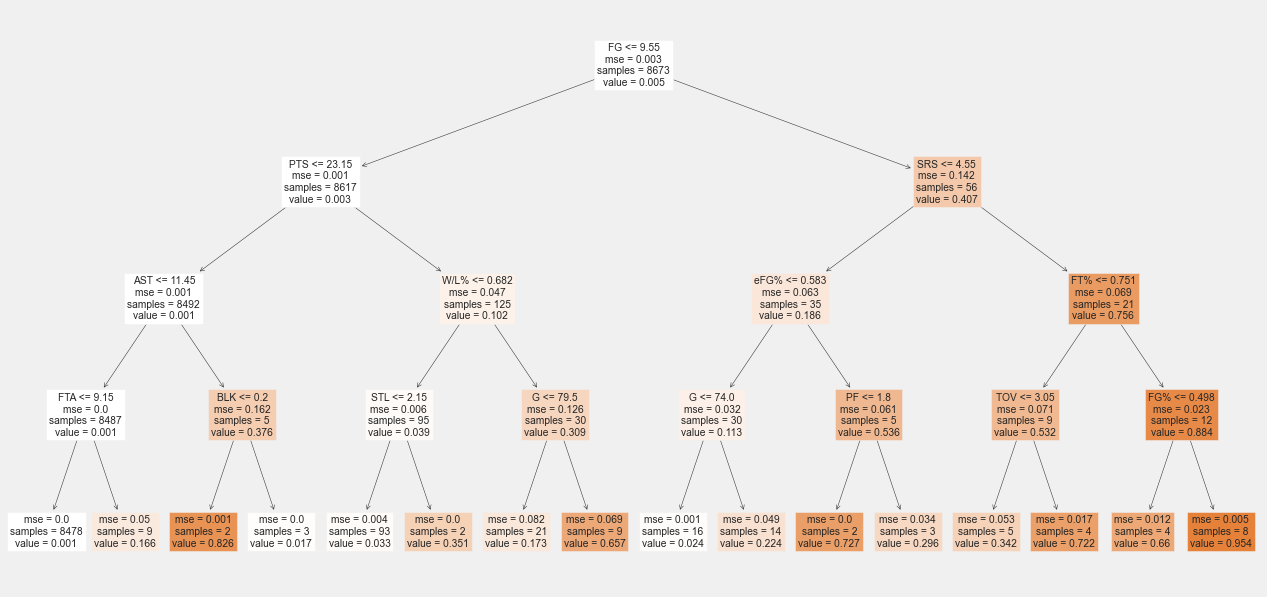

In [42]:
fig = plt.figure(figsize=(20,10))
tree.plot_tree(rf_small.estimators_[9], filled = True, feature_names=train[predictors].columns)
plt.show()
fig.savefig('figure_name.png')

**Thoughts**

Despite not all layers being present in the tree above, we can see that the root of the tree is either the PTS or FG variable, depending on which tree is being printed. The splitting value of approximately 27 points/game immediately splits up the game's top scorers from the rest of the pack. Similarly, splitting on approximately 10 FGs/per game also helps isolate the top scorers. MVP candidates are often prolific scorers, so it makes sense that these stats would be the roots of the tree.

### Ridge Regression

In [43]:
mean_ap_ridge, aps_ridge, all_predictions_ridge = backtest(stats_df, reg, years[5:], predictors)

In [44]:
print('Ridge regression average precision score = {}'.format(mean_ap_ridge))

Ridge regression average precision score = 0.7163411286514896


#### Visualizing the Average Precision Scores for the Ridge Regression

In [45]:
ridge_aps_df = pd.DataFrame({'Year': years[5:], 'aps': aps_ridge, 'mean_ap': mean_ap_ridge})
ridge_aps_df['Above Average'] = ridge_aps_df['aps']> ridge_aps_df['mean_ap']

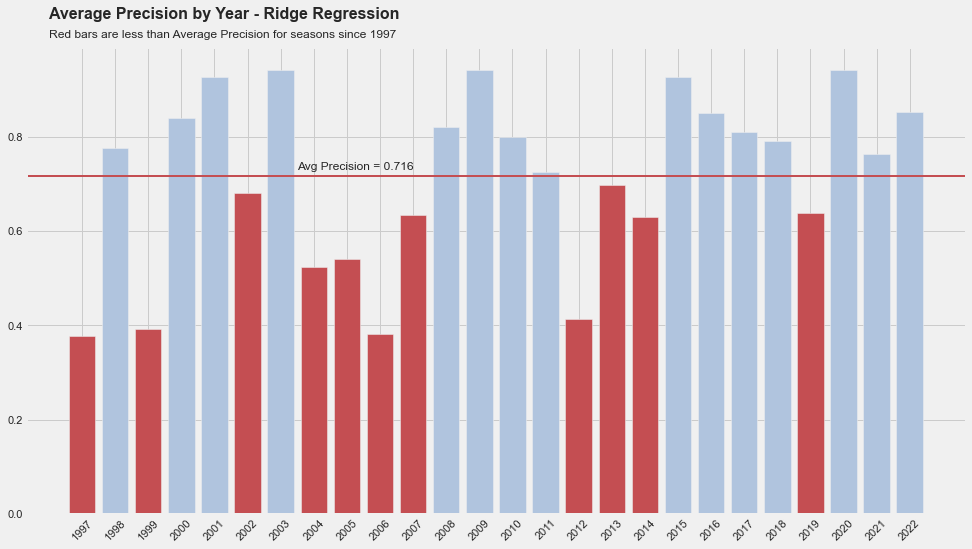

In [46]:
rounded_mean_ap_ridge = round(mean_ap_ridge, 3)

colors = []
for ap in aps_ridge:
    if ap > mean_ap_ridge:
        colors.append('lightsteelblue')
    else:
        colors.append('r')
        
plt.style.use('fivethirtyeight')        
fig = plt.figure(figsize=(15,8))
plt.bar(ridge_aps_df['Year'], ridge_aps_df['aps'], color = colors)
plt.axhline(y=mean_ap_ridge, color='r', linestyle='-', linewidth = 2)
plt.xticks(years[5:], rotation = 45)
plt.text(2003.5 ,.73,'Avg Precision = {}'.format(rounded_mean_ap_ridge), fontsize = 12)
plt.text(x=1996, y=1.05 , s='Average Precision by Year - Ridge Regression', fontsize=16, fontweight='semibold')
plt.text(x=1996, y=1.01 , s='Red bars are less than Average Precision for seasons since 1997', fontsize=12)
plt.show()

## Conclusion

Between the Ridge Regression and the Random Forest Regression, the Random Forest appears to have the slight edge in giving us a more accurate prediction of the top 5 MVP vote-getters. The Ridge Regression had a superior average precision score when just testing it out for 2022, however when backtesting, there was a drop in precision, which is to be expected.

### Potential Ways to Improve the Predictions
- Introduce advanced statistics, such as usage, win shares, VORP, plus/minus, etc. 
- Experiment with the number of years included in the analysis. The analysis currently looks back at the previous 30 years, but maybe more data would help the accuracy. Conversely, MVP voting patterns from 20-30 years ago may no longer apply to today's MVP voting, so we could also slightly limit the number of years included.
- Try to acquire data on the number of nationally televised games for each player. If a top player is playing more nationally televised games than the other MVP contenders, then they might be able to capitalize on getting more screen time to impress the MVP voters.